In [2]:
import energyflow as ef
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchsummary import summary
import gc


In [3]:
pts = []
etas = []
gen_pts = []
area=[]
npvs=[]
jec=[]

data = ef.mod.load(amount=0.05, cache_dir='~/.energyflow',
                    dataset='sim', subdatasets=None) 
for j in range(len(data.jet_pts)):

    pts.append(data.jet_pts[j])
    etas.append(data.jet_etas[j])
    area.append(data.jet_areas[j])
    npvs.append(data.npvs[j])
    gen_pts.append(data.gen_jet_pts[j])
    jec.append(data.jecs[j])

x=np.transpose([pts,etas,area,npvs,jec])
y=np.array(gen_pts)

#optimization
del pts, etas, gen_pts, area, npvs, jec
gc.collect()

0

In [4]:
from sklearn.model_selection import train_test_split
x_train_0, x_test_0, y_train_0, y_test_0 = train_test_split(x, y, test_size=0.2, shuffle=True)
x_train_0,x_vali_0,y_train_0,y_vali_0 = train_test_split(x_train_0 , y_train_0 , test_size=0.4, shuffle=True)

#Optimization
del x,y
gc.collect()



0

In [5]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Fit the scaler on the training data and transform the training, validation, and test data
x_train_0 = scaler_x.fit_transform(x_train_0)
x_vali_0 = scaler_x.transform(x_vali_0)
x_test_0 = scaler_x.transform(x_test_0)

y_train_0 = scaler_y.fit_transform(y_train_0.reshape(-1, 1)).flatten()
y_vali_0 = scaler_y.transform(y_vali_0.reshape(-1, 1)).flatten()
y_test_0 = scaler_y.transform(y_test_0.reshape(-1, 1)).flatten()



In [6]:
from torch.utils.data import DataLoader, TensorDataset
x_train = torch.tensor(x_train_0[:, :-1],dtype=torch.float32)
y_train = torch.tensor(y_train_0, dtype=torch.float32)
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=1024, shuffle=True)

y_vali = torch.tensor(y_vali_0, dtype=torch.float32)
x_vali = torch.tensor(x_vali_0[:, :-1], dtype=torch.float32)
vali_ds = TensorDataset(x_vali, y_vali)
vali_dl = DataLoader(vali_ds, batch_size=1024, shuffle=True)

print(x_train.shape, y_train.shape, x_vali.shape, y_vali.shape)

del x_train_0, y_train_0
gc.collect()

torch.Size([918536, 4]) torch.Size([918536]) torch.Size([612358, 4]) torch.Size([612358])


0

In [7]:
# controlliamo se la GPU è disponibile e nel caso quale tipo di GPU
if torch.cuda.is_available():
  print('Numero di GPU disponibili: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

# se la GPU è disponibile setto device='cuda', altrimenti 'cpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cpu



In [8]:
class ShallowMLP(nn.Module):
  def __init__(self, input_dim=4, output_dim=1, first_hidden_dim=128,second_hidden_dim=256,third_hidden_dim=128):
    super(ShallowMLP, self).__init__()

    # inizializzazione dei layer/funzioni che utilizzeremo per definire la rete

    #torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
    self.layer1 = nn.Linear(input_dim, first_hidden_dim)  #hidden layer
    self.layer2 = nn.Linear(first_hidden_dim, first_hidden_dim)
    self.layer3 = nn.Linear(first_hidden_dim, second_hidden_dim)

    self.layer4 = nn.Linear(second_hidden_dim, third_hidden_dim) 
    self.layer5 = nn.Linear(third_hidden_dim, output_dim)

    self.relu = nn.ReLU() # relu function (NOTA: non è obbligatorio definirla qui, è anche possible usare la forma funzionale F.relu() direttamente nel metodo forward())


  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x) 
    x = self.layer2(x)
    x = self.relu(x)
    x= self.layer3(x)
    x = self.relu(x)
    x = self.layer4(x)
    x = self.relu(x)
    out = self.layer5(x)
    
    return out
  

model = ShallowMLP()
summary(model, (4,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             640
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              ReLU-4                  [-1, 128]               0
            Linear-5                  [-1, 256]          33,024
              ReLU-6                  [-1, 256]               0
            Linear-7                  [-1, 128]          32,896
              ReLU-8                  [-1, 128]               0
            Linear-9                    [-1, 1]             129
Total params: 83,201
Trainable params: 83,201
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.32
Estimated Total Size (MB): 0.33
---------------------------------------------

In [9]:
#testiamo il modello
x,_ = next(iter(train_dl)) #è un AE non ci servono le label
x=x.to(device)
xtilde = model(x)
print(xtilde.shape)

del x, xtilde
gc.collect()

torch.Size([1024, 1])


0

In [ ]:
class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss

    def __call__(self, current_valid_loss, epoch, model, optimizer, criterion):

        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss

            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")



            torch.save({'model' : model,
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss function': criterion,
                'loss': current_valid_loss,
                },'../models/current_trial/best_model_genpts.pt' )

            return 1
        else:
          return 0

#carica il modello
def load_model(save_path='../models/current_trial/best_model_genpts.pt', model_class=None):
    checkpoint = torch.load(save_path,map_location=torch.device('cpu') )

    model = model_class()

    model.load_state_dict(checkpoint['model_state_dict'])

    return model

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/25, Train Loss: 0.019866125, Validation Loss: 0.017852820

Best validation loss: 0.017852819648929912

Saving best model for epoch: 1

Epoch 2/25, Train Loss: 0.017897915, Validation Loss: 0.017874474
Epoch 3/25, Train Loss: 0.017804085, Validation Loss: 0.017954026
Epoch 4/25, Train Loss: 0.017743056, Validation Loss: 0.017948420
Epoch 5/25, Train Loss: 0.017719823, Validation Loss: 0.017710612

Best validation loss: 0.017710611960569896

Saving best model for epoch: 5

Epoch 6/25, Train Loss: 0.017692923, Validation Loss: 0.017630244

Best validation loss: 0.01763024386459808

Saving best model for epoch: 6

Epoch 7/25, Train Loss: 0.017676198, Validation Loss: 0.017674537
Epoch 8/25, Train Loss: 0.017664294, Validation Loss: 0.017618430

Best validation loss: 0.017618429590704743

Saving best model for epoch: 8

Epoch 9/25, Train Loss: 0.017648089, Validation Loss: 0.018369631
Epoch 10/25, Train Loss: 0.017640652, Validation Loss: 0.017554371

Best validation loss: 0.0175543

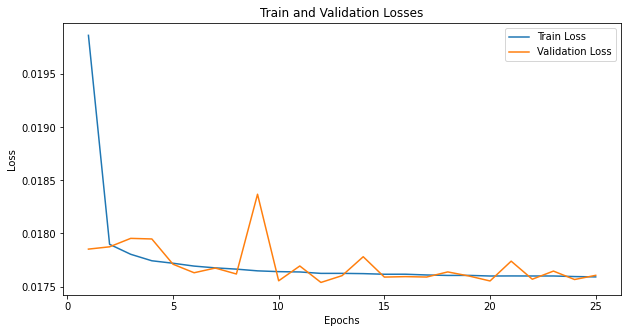

In [11]:

save_best_model = SaveBestModel()
num_epochs = 25
train_losses = []
vali_losses = []

for epoch in range(num_epochs):
    #training
    model.train()
    running_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    
    train_loss = running_loss / len(train_dl.dataset)
    train_losses.append(train_loss)
    
    #validation step
    model.eval()
    running_vali_loss = 0.0
    with torch.no_grad():
        for xb, yb in vali_dl:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb.unsqueeze(1))
            running_vali_loss += loss.item() * xb.size(0)
    
    vali_loss = running_vali_loss / len(vali_dl.dataset)
    vali_losses.append(vali_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.9f}, Validation Loss: {vali_loss:.9f}")

    # Save the model
    save_best_model(vali_loss, epoch, model, optimizer, criterion)

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), vali_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.show()

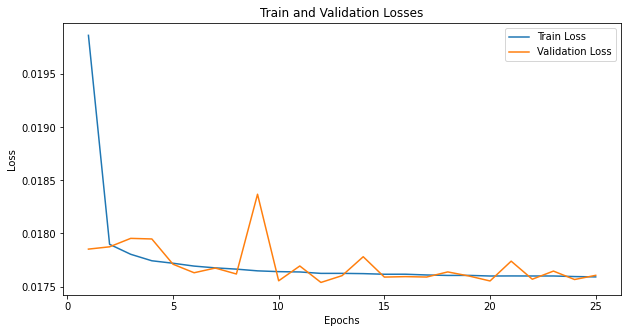

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), vali_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.savefig('losses_2.pdf')

In [12]:
# Evaluate the model on the test set
model= load_model('../models/current_trial/best_model_genpts.pt', model_class=lambda: ShallowMLP())
model.to(device)
model.eval()
x_test_tensor = torch.tensor(x_test_0, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_0, dtype=torch.float32)


Test MSE: 0.016703052446246147


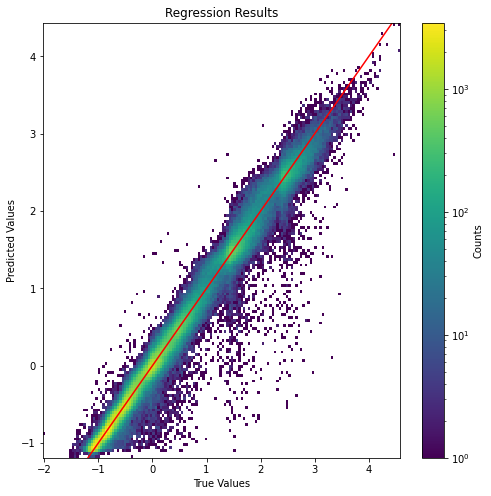

In [13]:
from matplotlib.colors import LogNorm
with torch.no_grad():
    y_pred_tensor = model(x_test_tensor[:,:-1])
    test_loss = criterion(y_pred_tensor, y_test_tensor.unsqueeze(1)).item()
print(f"Test MSE: {test_loss}")

# Scatter plot of true vs predicted values
plt.figure(figsize=(8, 8))
plt.hist2d(y_test_tensor.numpy().flatten(), y_pred_tensor.numpy().flatten(), bins=150, cmap='viridis', norm=LogNorm())
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Regression Results')
plt.plot([min(y_test_tensor.numpy().flatten()), max(y_test_tensor.numpy().flatten())], [min(y_test_tensor.numpy().flatten()), max(y_test_tensor.numpy().flatten())], color='red')  # Perfect fit line
plt.colorbar(label='Counts')
plt.savefig('regression_2.pdf')
plt.show()


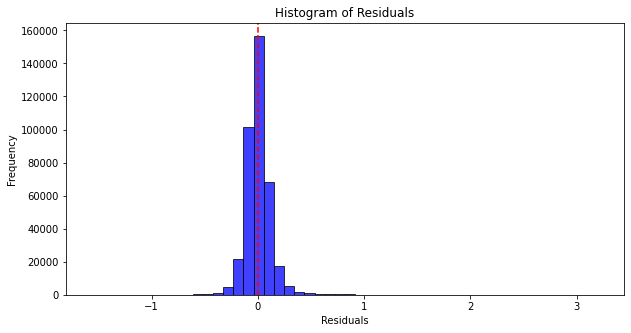

In [14]:
# Calculate residuals
residuals = y_test_tensor.numpy().flatten()-y_pred_tensor.numpy().flatten()

# Plot histogram of residuals
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.savefig('residuals_2.pdf')
plt.show()

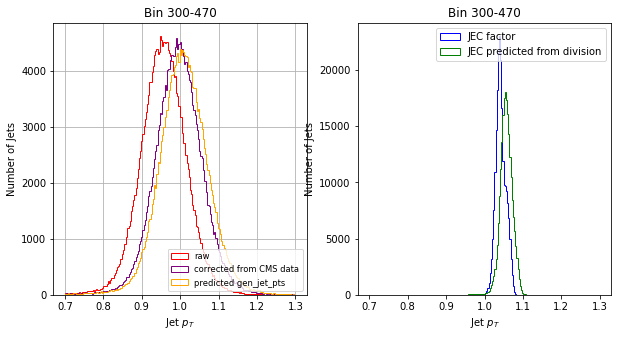

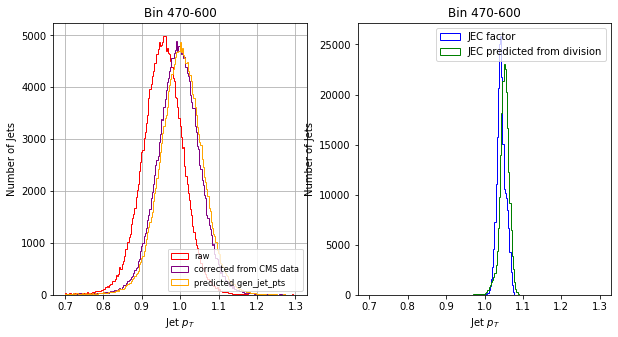

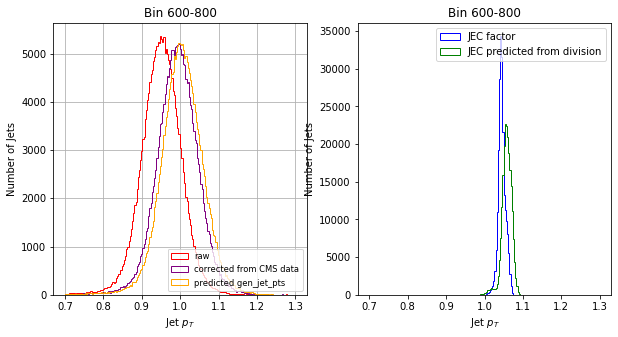

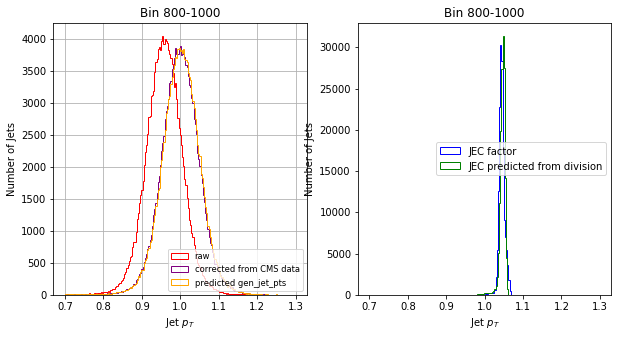

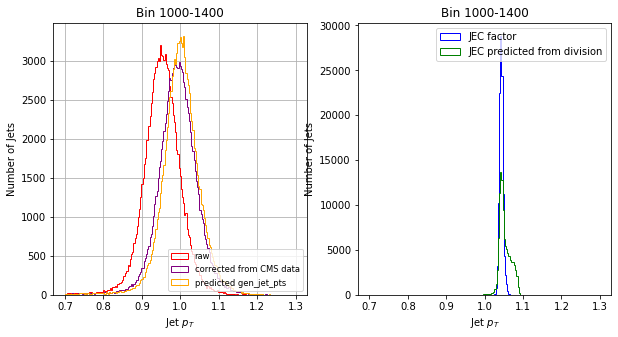

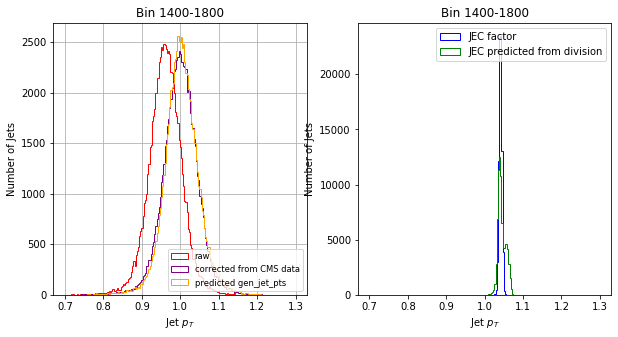

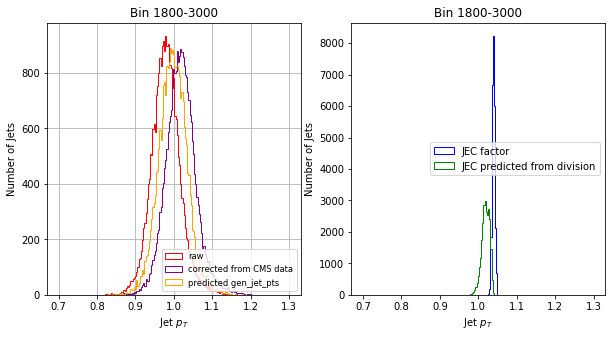

In [15]:
bins=np.array([300,470,600,800,1000,1400,1800,3000])
# Unify test and validation sets
x_test_vali = np.concatenate((x_test_0, x_vali_0), axis=0)
y_test_vali = np.concatenate((y_test_0, y_vali_0), axis=0)
mask_variable=scaler_x.inverse_transform(x_test_vali)[:,0]
# Apply the mask to the unified test and validation sets

for i in range(len(bins) - 1):
    mask = (np.array(mask_variable) >= bins[i]) & (np.array(mask_variable) < bins[i + 1])
    
    # Prepare the input for the model
    x_bin = x_test_vali[mask][:, :-1]
    x_bin_tensor = torch.tensor(x_bin, dtype=torch.float32).to(device)

    # Predict JEC using the model
    with torch.no_grad():
        gen_jet_pred_tensor = model(x_bin_tensor).cpu().numpy().flatten()
    
    # Denormalize the predicted JEC
    gen_jet_pred_tensor = scaler_y.inverse_transform(gen_jet_pred_tensor.reshape(-1, 1)).flatten()

    x_prime = scaler_x.inverse_transform(x_test_vali[mask])
    y_prime = scaler_y.inverse_transform(y_test_vali[mask].reshape(-1, 1)).flatten()

    pts_bin = np.array(x_prime[:,0])
    etas_bin = np.array(x_prime[:,1])
    jec_bin = np.array(x_prime[:,4])
    gen_pts_bin = np.array(y_prime)

    gen_pts_pred = np.array(gen_jet_pred_tensor)
    jec_pred=gen_pts_pred/pts_bin

    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # Adjusted figsize for better visualization

    # Plot 1D histograms
    ax[0].hist(pts_bin / gen_pts_bin, bins=np.linspace(0.7,1.3,200), histtype="step", color="red", label="raw")
    ax[0].hist(pts_bin * jec_bin / gen_pts_bin, bins=np.linspace(0.7,1.3,200) , histtype="step", color="purple", label="corrected from CMS data")
    ax[0].hist(gen_pts_pred / gen_pts_bin, bins=np.linspace(0.7,1.3,200), histtype="step", color="orange", label="predicted gen_jet_pts")
    #ax[0].hist(gen_pts_bin, bins=np.linspace(0.7,1.3,200), histtype="step", color="blue", label="truth")
    ax[0].set_xlabel("Jet $p_T$")
    ax[0].set_ylabel("Number of Jets")
    ax[0].grid(True)
    ax[0].set_title(f"Bin {bins[i]}-{bins[i + 1]}")
    ax[0].legend(loc='lower right', fontsize='small')
    
    ax[1].hist(jec_bin, bins=np.linspace(0.7, 1.3, 200), histtype="step", color="blue", label="JEC factor")
    ax[1].hist(jec_pred, bins=np.linspace(0.7, 1.3, 200), histtype="step", color="green", label="JEC predicted from division")
    ax[1].set_xlabel("Jet $p_T$")
    ax[1].set_ylabel("Number of Jets")
    ax[1].set_title(f"Bin {bins[i]}-{bins[i + 1]}")
    ax[1].legend()
    plt.savefig(f'jec_{bins[i]}_{bins[i + 1]}_2.pdf')
    
    plt.show()


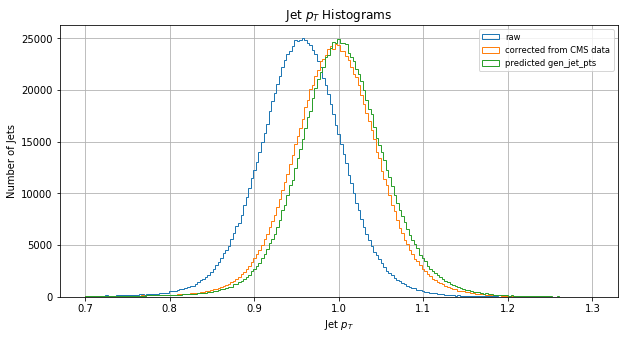

mean CMS sim= 0.9939798708198865 mean our simulation 1.0018326789210186
std CMS sim= 0.473012512882 std our simulation 0.4754803117234363


In [16]:
# Unify test and validation sets
mask_variable = scaler_x.inverse_transform(x_test_vali)[:, 0]

# Prepare the input for the model
x_bin = x_test_vali[:, :-1]
x_bin_tensor = torch.tensor(x_bin, dtype=torch.float32).to(device)

# Predict JEC using the model
with torch.no_grad():
    gen_jet_pred_tensor = model(x_bin_tensor).cpu().numpy().flatten()

# Denormalize the predicted JEC
gen_jet_pred_tensor = scaler_y.inverse_transform(gen_jet_pred_tensor.reshape(-1, 1)).flatten()

x_prime = scaler_x.inverse_transform(x_test_vali)
y_prime = scaler_y.inverse_transform(y_test_vali.reshape(-1, 1)).flatten()

pts_bin = np.array(x_prime[:, 0])
etas_bin = np.array(x_prime[:, 1])
jec_bin = np.array(x_prime[:, 4])
gen_pts_bin = np.array(y_prime)

gen_pts_pred = np.array(gen_jet_pred_tensor)
jec_pred = gen_pts_pred / pts_bin

# Plot 1D histograms
plt.figure(figsize=(10, 5))
plt.hist(pts_bin / gen_pts_bin, bins=np.linspace(0.7,1.3,200), histtype="step", label="raw")
plt.hist(pts_bin * jec_bin / gen_pts_bin, bins=np.linspace(0.7,1.3,200), histtype="step", label="corrected from CMS data")
plt.hist(gen_pts_pred / gen_pts_bin, bins=np.linspace(0.7,1.3,200), histtype="step", label="predicted gen_jet_pts")
#plt.hist(gen_pts_bin / gen_pts_bin, bins=np.linspace(0.7,1.3,200), histtype="step", label="truth")

plt.xlabel("Jet $p_T$")
plt.ylabel("Number of Jets")
plt.title("Jet $p_T$ Histograms")
plt.grid()
plt.legend(loc='upper right', fontsize='small')
plt.savefig('jec_2_normalized.pdf')
plt.show()

print('mean CMS sim=',np.mean(pts_bin * jec_bin / gen_pts_bin),'mean our simulation', np.mean(gen_pts_pred / gen_pts_bin))
print('std CMS sim=',np.std(pts_bin * jec_bin / gen_pts_bin),'std our simulation', np.std(gen_pts_pred / gen_pts_bin))

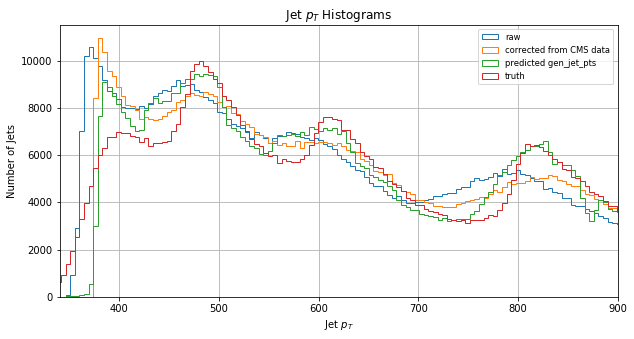

In [20]:
# Unify test and validation sets
x_test_vali = np.concatenate((x_test_0, x_vali_0), axis=0)
y_test_vali = np.concatenate((y_test_0, y_vali_0), axis=0)
mask_variable = scaler_x.inverse_transform(x_test_vali)[:, 0]

# Prepare the input for the model
x_bin = x_test_vali[:, :-1]
x_bin_tensor = torch.tensor(x_bin,dtype=torch.float32).to(device)

# Predict JEC using the model
with torch.no_grad():
    gen_jet_pred_tensor = model(x_bin_tensor).cpu().numpy().flatten()

# Denormalize the predicted JEC
gen_jet_pred_tensor = scaler_y.inverse_transform(gen_jet_pred_tensor.reshape(-1, 1)).flatten()

x_prime = scaler_x.inverse_transform(x_test_vali)
y_prime = scaler_y.inverse_transform(y_test_vali.reshape(-1, 1)).flatten()

pts_bin = np.array(x_prime[:, 0])
etas_bin = np.array(x_prime[:, 1])
jec_bin = np.array(x_prime[:, 4])
gen_pts_bin = np.array(y_prime)

gen_pts_pred = np.array(gen_jet_pred_tensor)
jec_pred = gen_pts_pred / pts_bin

# Plot 1D histograms
plt.figure(figsize=(10, 5))
plt.hist(pts_bin, bins=np.linspace(300,2600,500), histtype="step", label="raw")
plt.hist(pts_bin * jec_bin, bins=np.linspace(300,2600,500), histtype="step", label="corrected from CMS data")
plt.hist(gen_pts_pred, bins=np.linspace(300,2600,500), histtype="step", label="predicted gen_jet_pts")
plt.hist(gen_pts_bin, bins=np.linspace(300,2600,500), histtype="step", label="truth")

plt.xlabel("Jet $p_T$")
plt.ylabel("Number of Jets")
plt.xlim(340,900)
plt.title("Jet $p_T$ Histograms")
plt.grid()
plt.legend(loc='upper right', fontsize='small')
plt.savefig('jec_2.pdf')
plt.show()

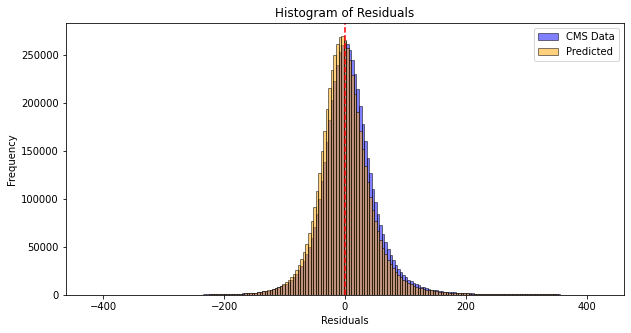

Mean of Residuals CMS Data: 7.3423
Mean of Residuals Predicted: 1.2523
Residuals CMS Data Std: 55.4648
Residuals Predicted Std: 54.0977
Sum of Residuals CMS Data: 199493366.9284
Sum of Residuals Predicted: 193348812.8007


: 

In [ ]:
# Calculate residuals
residuals_cms = gen_pts_bin - (pts_bin * jec_bin)
residuals_pred = gen_pts_bin - gen_pts_pred

# Plot histograms of residuals
plt.figure(figsize=(10, 5))
plt.hist(residuals_cms, bins=np.linspace(-420,420,200), alpha=0.5, color='blue', edgecolor='black', label='CMS Data')
plt.hist(residuals_pred, bins=np.linspace(-420,420,200), alpha=0.5, color='orange', edgecolor='black', label='Predicted')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.legend()
plt.savefig('residuals_not_norm_2.jpg')
plt.show()

# Print the mean of the residuals for both
print(f"Mean of Residuals CMS Data: {np.mean(residuals_cms):.4f}")
print(f"Mean of Residuals Predicted: {np.mean(residuals_pred):.4f}")

# Print the residual distribution standard deviation for both
print(f"Residuals CMS Data Std: {np.std(residuals_cms):.4f}")
print(f"Residuals Predicted Std: {np.std(residuals_pred):.4f}")

# Print the sum of the residuals for both
print(f"Sum of Residuals CMS Data: {np.sum(np.abs(residuals_cms)):.4f}")
print(f"Sum of Residuals Predicted: {np.sum(np.abs(residuals_pred)):.4f}")